In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jrandom
import matplotlib.pyplot as plt

In [3]:
def lerp(a, b, x):
    # 0 <= x <= 1
    return a + x * (b - a)

def bilinear(x, weights):
    # Linear interpolate twice
    ftop = lerp(weights[0, 0], weights[0, 1], x[0])
    fbottom = lerp(weights[1, 0], weights[1, 1], x[0])
    return lerp(ftop, fbottom, x[1])

def bilinear_matrix(x, weights):
    left = jnp.array([1 - x[0], x[0]])
    right = jnp.array([1 - x[1], x[1]])
    return jnp.dot(left, weights.T @ right)

bilinear_grid = jax.vmap(jax.vmap(bilinear, in_axes=(0, None)), in_axes=(0, None))
bilinear_grid_matrix = jax.vmap(jax.vmap(bilinear_matrix, in_axes=(0, None)), in_axes=(0, None))

In [4]:
grid = jnp.meshgrid(jnp.linspace(0, 1, 11), jnp.linspace(0, 1, 11))
grid = jnp.stack(grid, axis=-1)
grid.shape

(11, 11, 2)

In [5]:
key = jrandom.PRNGKey(3)
weights = jrandom.uniform(key, (2, 2), minval=-1, maxval=1)
print(weights)

gridvals = bilinear_grid(grid, weights)
gridvals_matrix = bilinear_grid_matrix(grid, weights)

[[-0.52292466 -0.97776127]
 [ 0.2124865  -0.33039665]]


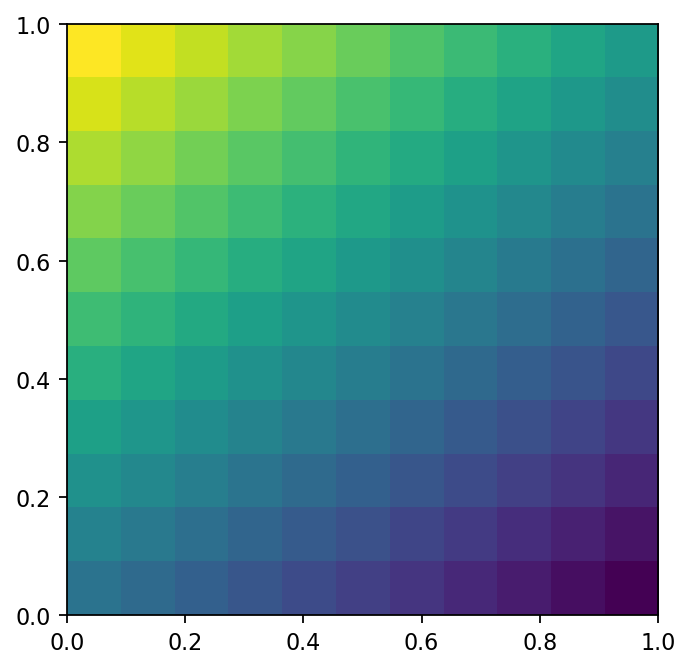

In [6]:
plt.imshow(gridvals, extent=[0, 1, 0, 1], origin='lower')

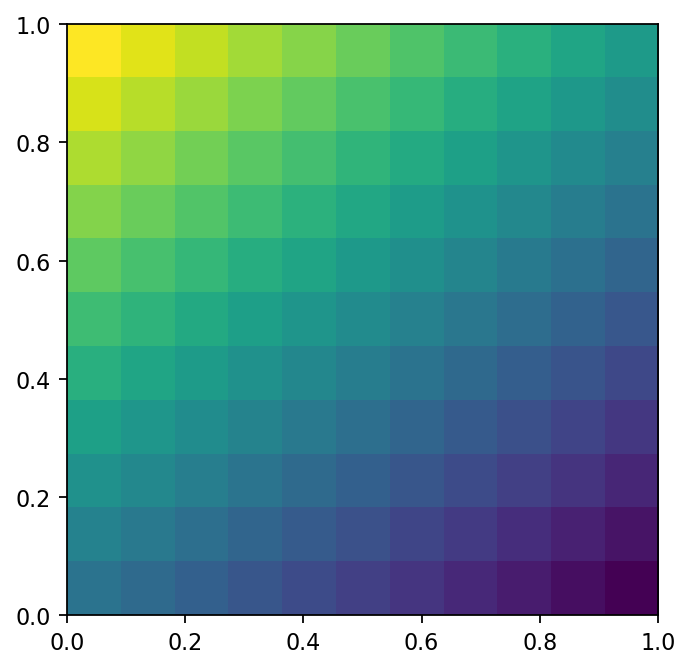

In [7]:
plt.imshow(gridvals_matrix, extent=[0, 1, 0, 1], origin='lower')

In [8]:
bilinear_spatial_grad = jax.grad(bilinear, argnums=0)
bilinear_spatial_grad_grid = jax.vmap(jax.vmap(bilinear_spatial_grad, in_axes=(0, None)), in_axes=(0, None))

In [9]:
grad_gridval = bilinear_spatial_grad_grid(grid, weights)
grad_gridval.shape

(11, 11, 2)

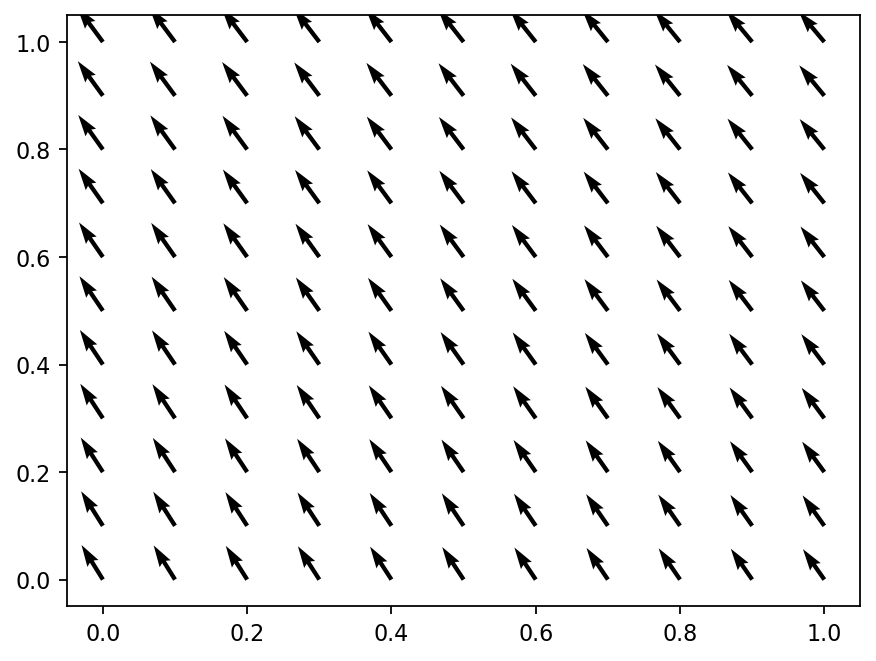

In [10]:
# Plot vector field
plt.quiver(grid[:, :, 0], grid[:, :, 1], grad_gridval[:, :, 0], grad_gridval[:, :, 1])

In [11]:
# Now sample gradient at corners and interpolate it
positions = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
positions

Array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32)

In [12]:
sampled_grads = jax.vmap(bilinear_spatial_grad, in_axes=(0, None))(positions, weights)

In [13]:
sampled_grads

Array([[-0.4548366 ,  0.73541117],
       [-0.54288316,  0.73541117],
       [-0.4548366 ,  0.6473646 ],
       [-0.54288316,  0.6473646 ]], dtype=float32)

In [14]:
# What do we do when some points are invalid (inside the level set)?
# For 3 points set the last point to be the average of its adjacent points and carry on normally
# For 2 points, the integral happens in a field with constant gradient
# For 1 point, use that point value

# Test what happens with 3 points
defined_weights = np.random.normal(size=(3,))
final_weight = np.mean(defined_weights[-2:])
print(f'{final_weight=}')
wonky_weights = np.concatenate([defined_weights, [final_weight]])
print(wonky_weights)
wonky_weights = jnp.array(wonky_weights.reshape(2, 2))
wonky_weights

final_weight=1.3860673337233487
[-1.33155501  1.03711494  1.73501973  1.38606733]


Array([[-1.331555 ,  1.037115 ],
       [ 1.7350197,  1.3860674]], dtype=float32)

In [15]:
gridvals = bilinear_grid(grid, wonky_weights)
grad_gridvals = bilinear_spatial_grad_grid(grid, wonky_weights)

-1.331555 -1.094688 -1.0248976 -0.81520677


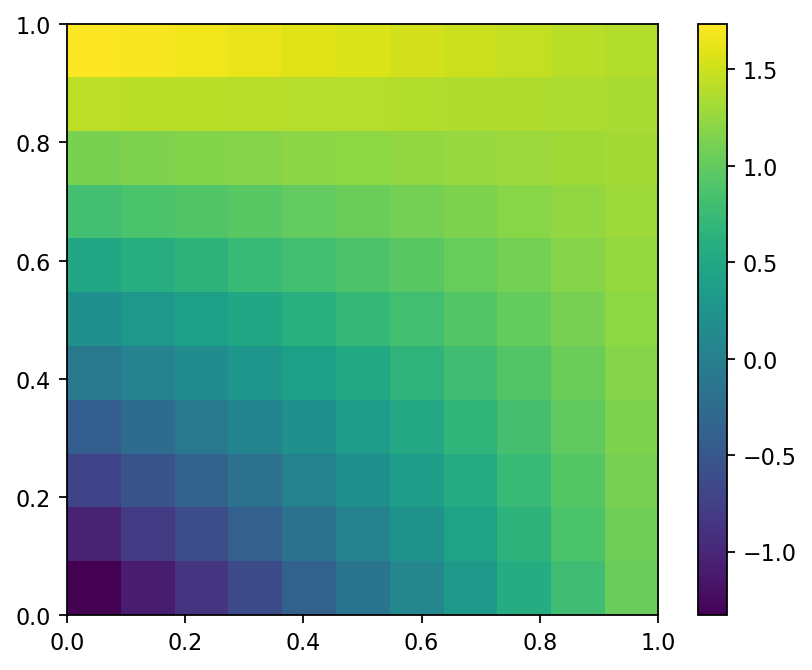

In [16]:
plt.imshow(gridvals, extent=[0, 1, 0, 1], origin='lower')
print(gridvals[0, 0], gridvals[0, 1], gridvals[1, 0], gridvals[1, 1])
plt.colorbar()

[[2.36867    3.0665746 ]
 [2.36867    2.7948127 ]
 [2.36867    2.5230503 ]
 [2.36867    2.251288  ]
 [2.36867    1.9795258 ]
 [2.36867    1.7077636 ]
 [2.36867    1.4360013 ]
 [2.36867    1.164239  ]
 [2.36867    0.8924769 ]
 [2.36867    0.62071455]
 [2.36867    0.3489524 ]]


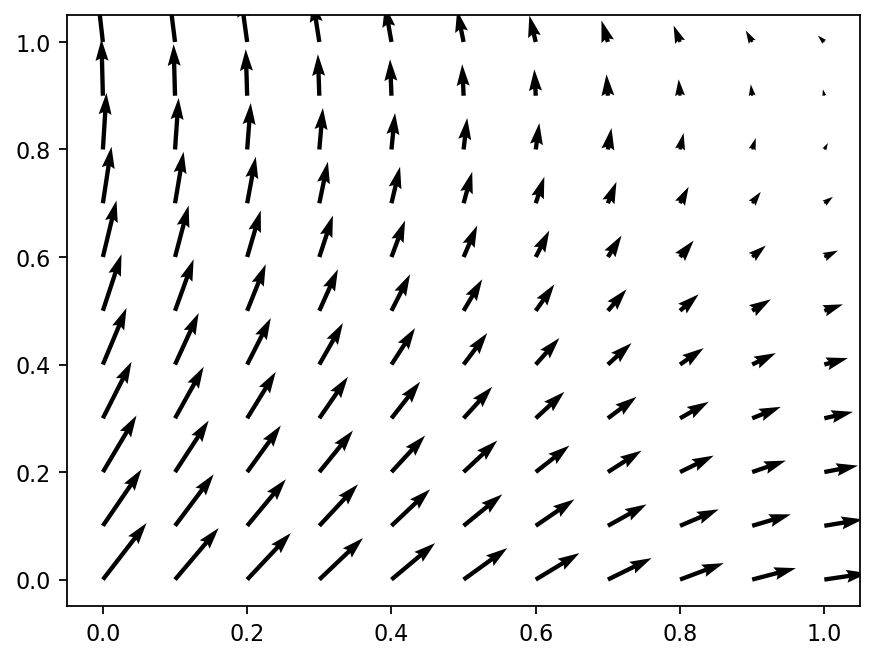

In [17]:
print(grad_gridvals[0, :, :])
plt.quiver(grid[:, :, 0], grid[:, :, 1], grad_gridvals[:, :, 0], grad_gridvals[:, :, 1])

[2.36867   3.0665746]


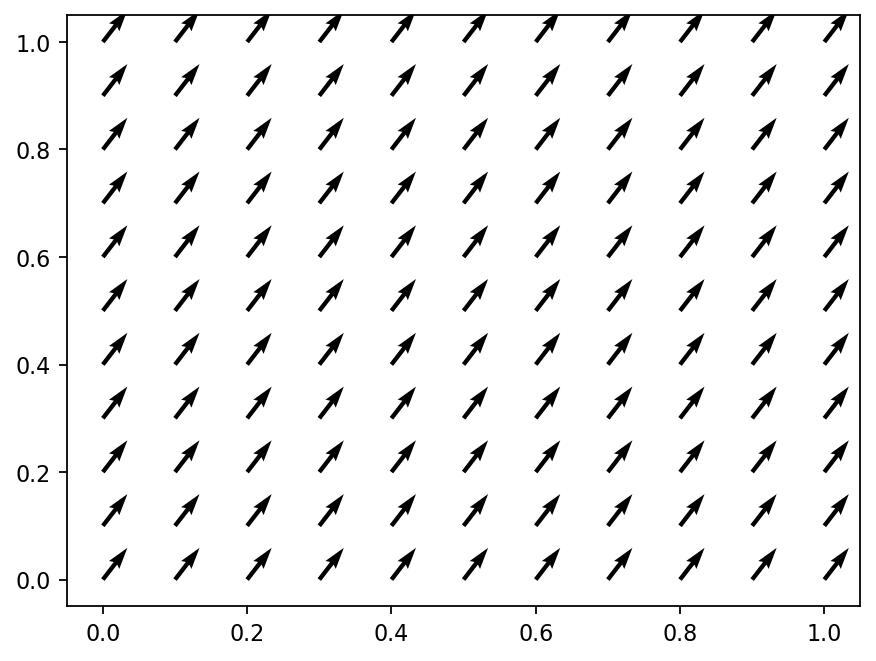

In [18]:
# Instead we could interpolate as a plane, found by computing the total gradient vector (using the hat basis) which is constant on the plane
# then the inner product of this gradient with the vector from the point to the corner gives the change in value from that corner
grad_vec = jnp.array([wonky_weights[0, 1] - wonky_weights[0, 0], wonky_weights[1, 0] - wonky_weights[0, 0]])
print(grad_vec)
plt.quiver(grid[:, :, 0], grid[:, :, 1], grad_vec[0], grad_vec[1])

-1.331555 -1.094688 -1.0248976 -0.78803056


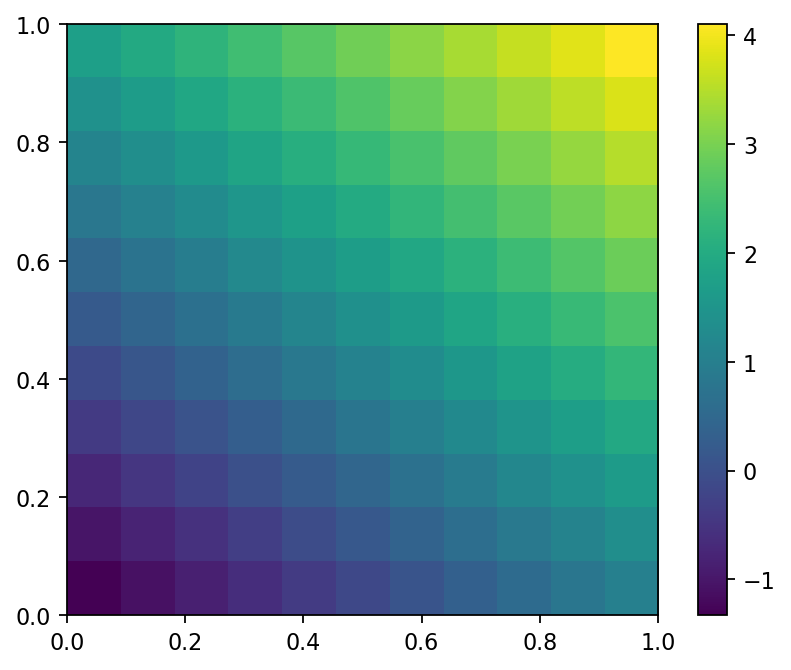

In [19]:
# Now compute distances using this gradient
new_vals = wonky_weights[0, 0] + jnp.einsum('k,ijk->ij', grad_vec, grid)  # grad_vec - (0, 0)
plt.imshow(new_vals, extent=[0, 1, 0, 1], origin='lower')
print(new_vals[0, 0], new_vals[0, 1], new_vals[1, 0], new_vals[1, 1])
plt.colorbar()